In [ ]:
import numpy as np
import math
from collections import defaultdict

class Qlearning(object):
    def __init__(self,n_states,n_actions,cfg):
        self.n_actions = n_actions
        self.lr = cfg.lr
        self.gamma = cfg.gamma
        self.sample_count = 0
        self.epsilon_start = cfg.epsilon_strat
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table = defaultdict(lambda: np.zeros(n_actions))#用字典存放状态-》动作-》状态-》动作值 也就是Q表

    def sample_action(self,state):#采样动作pair，用于训练
        self.sample_count +=1
        self.epsilon = self.epsilon_end+(self.epsilon_start-self.epsilon_end)*\
            math.exp(-1. * self.sample_count / self.epsilon_decay)# epsilon是会递减的，这里选择指数递减
        #这里就是策略选择动作，就是说随机数如果大于epsilon就选择最大的动作值，否则就随机选择一个动作
        #为什么选择这样是因为我想要我的采样具有一定的随机性质也就是说希望具有一定的探索性质
        if np.random.uniform(0,1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)])
        else:
            action = np.random.choice(self.n_actions)
        return action

    def predict_action(self,state):
        action  = np.argmax(self.Q_table[str(state)])
        return action
    
    def update(self,state,action,reward,next_state,terminated):#off policy的Qlearing是更新Q值其实这里就是policy evaluation
        Q_predict = self.Q_table[str(state)][action] #这个是单次的采样值
        if terminated:
            Q_traget = reward
        else:
            Q_traget = reward + self.gamma * np.max(self.Q_table[str(next_state)])
        self.Q_table[str(state)][action] += self.lr * (Q_traget-Q_predict)


In [ ]:
from argparse import Action


def train(cfg,env,agent):
    print('开始训练')
    print(f'环境信息：{cfg.env_name}')
    rewards = [] #记录奖励
    for i_ep in range(cfg.train_eps):
        #重置奖励重置环境、
        ep_reward = 0 
        state,_ = env.reset(seed = cfg.seed)
        while True:
            action = agent.sample_action(state) #输出状态，产生动作
            next_state,reward,terminated,truncated,info = env.step(action) #在环境中产生动作，得到这个动作会导致的结果
            agent.update(state,action,reward,next_state,terminated) # Q学习算法更新
            state = next_state
            ep_reward += reward
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%10 == 0: #告诉我们模型在训练也就是和我们说我们的策略更新以后的实际的那一个回合的情况让我们的训练可以被观测
            print(f'回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，epsilon：{agent.epsilon:.3f}')
    print('完成训练！')
    return {"rewards":rewards}

def test(cfg,env,agent):
    print("开始测试")
    rewards = [] #记录奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0
        state,_ = env.reset(seed = cfg.seed)
        while True:
            action = int(np.argmax(agent.Q_table[str(state)]))
            next_state,reward,terminated,truncated,info= env.step(action)
            state = next_state
            ep_reward += reward
            if terminated or truncated:
                break
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
        rewards.append(ep_reward)
    print('完成测试！')
    return {"rewards":rewards}

In [27]:
import gymnasium as gym
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html

class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

In [28]:

import gym
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    '''    
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = Qlearning(n_states,n_actions,cfg)
    return env,agent

In [29]:
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    def __init__(self):
        self.env_name = 'CliffWalking-v0'
        self.seed = 1
        self.train_eps = 10000
        self.test_eps = 20
        self.max_episodes = 100
        self.epsilon_strat = 0.95
        self.epsilon_end = 0.01
        self.epsilon_decay = 300
        self.lr = 0.1
        self.gamma = 0.9

def plot_rewards(rewards,title = "learing_curve"):
    sns.set()
    plt.figure()
    plt.xlim(0, len(rewards))  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards,label='rewards')
    plt.title(title)
    plt.show()

开始训练
环境信息：CliffWalking-v0
回合：10/10000，奖励：-168.00，epsilon：0.010
回合：20/10000，奖励：-72.00，epsilon：0.010
回合：30/10000，奖励：-78.00，epsilon：0.010
回合：40/10000，奖励：-38.00，epsilon：0.010
回合：50/10000，奖励：-57.00，epsilon：0.010
回合：60/10000，奖励：-72.00，epsilon：0.010
回合：70/10000，奖励：-66.00，epsilon：0.010
回合：80/10000，奖励：-40.00，epsilon：0.010
回合：90/10000，奖励：-52.00，epsilon：0.010
回合：100/10000，奖励：-46.00，epsilon：0.010
回合：110/10000，奖励：-34.00，epsilon：0.010
回合：120/10000，奖励：-34.00，epsilon：0.010
回合：130/10000，奖励：-40.00，epsilon：0.010
回合：140/10000，奖励：-42.00，epsilon：0.010
回合：150/10000，奖励：-36.00，epsilon：0.010
回合：160/10000，奖励：-25.00，epsilon：0.010
回合：170/10000，奖励：-16.00，epsilon：0.010
回合：180/10000，奖励：-21.00，epsilon：0.010
回合：190/10000，奖励：-22.00，epsilon：0.010
回合：200/10000，奖励：-25.00，epsilon：0.010
回合：210/10000，奖励：-21.00，epsilon：0.010
回合：220/10000，奖励：-25.00，epsilon：0.010
回合：230/10000，奖励：-15.00，epsilon：0.010
回合：240/10000，奖励：-13.00，epsilon：0.010
回合：250/10000，奖励：-18.00，epsilon：0.010
回合：260/10000，奖励：-13.00，epsilon：0.010
回合：270/10000，奖励：-13.

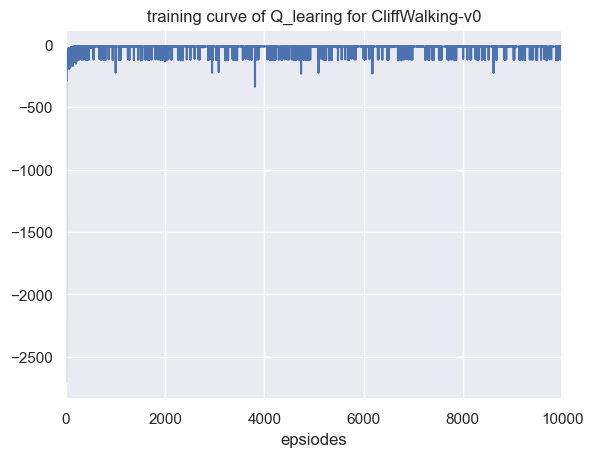

开始测试
回合数：1/20, 奖励：-13.0
回合数：2/20, 奖励：-13.0
回合数：3/20, 奖励：-13.0
回合数：4/20, 奖励：-13.0
回合数：5/20, 奖励：-13.0
回合数：6/20, 奖励：-13.0
回合数：7/20, 奖励：-13.0
回合数：8/20, 奖励：-13.0
回合数：9/20, 奖励：-13.0
回合数：10/20, 奖励：-13.0
回合数：11/20, 奖励：-13.0
回合数：12/20, 奖励：-13.0
回合数：13/20, 奖励：-13.0
回合数：14/20, 奖励：-13.0
回合数：15/20, 奖励：-13.0
回合数：16/20, 奖励：-13.0
回合数：17/20, 奖励：-13.0
回合数：18/20, 奖励：-13.0
回合数：19/20, 奖励：-13.0
回合数：20/20, 奖励：-13.0
完成测试！


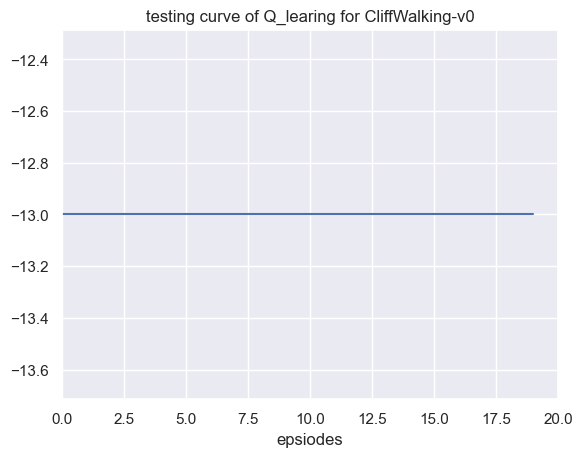

In [30]:
cfg = Config()
env,agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"training curve of Q_learing for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve of Q_learing for {cfg.env_name}")  # 画出结果